<a href="https://colab.research.google.com/github/mdhenis402/Dataset-Daun-Belimbing-Wuluh-dan-Jambu-Biji_402_415/blob/main/Daun_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Datasets

In [ ]:
# Ekstrak dataset

import os
import zipfile

local_zip = '/tmp/Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/Dataset'

train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Validation')

Validasi Dataset

In [ ]:
belimbing_train_path = train_dir + '/Belimbing_Wuluh'
jambu_train_path = train_dir + '/Jambu_Biji'
belimbing_val_path = val_dir + '/Belimbing_Wuluh'
jambu_val_path = val_dir + '/Jambu_Biji'

belimbing_len_train = len(os.listdir(belimbing_train_path))
jambu_len_train = len(os.listdir(jambu_train_path))
belimbing_len_val = len(os.listdir(belimbing_val_path))
jambu_len_val = len(os.listdir(jambu_val_path))

print("jumlah dataset Training : ", belimbing_len_train + jambu_len_train)
print("jumlah dataset validasi : ", belimbing_len_val + jambu_len_val)
print("\n\n")
print("jumlah train kelas Belimbing : ", belimbing_len_train)
print("jumlah train kelas Jambu : ", jambu_len_train)
print("jumlah validasi kelas Belimbing : ", belimbing_len_val)
print("jumlah validasi kelas Jambu : ", jambu_len_val)

jumlah dataset Training :  80
jumlah dataset validasi :  20



jumlah train kelas Belimbing :  40
jumlah train kelas Jambu :  40
jumlah validasi kelas Belimbing :  10
jumlah validasi kelas Jambu :  10


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Augmentasi

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Arsitektur Model

In [ ]:
'''
Import Library yang dibutuhkan
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten,Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
'''
definisikan dan setting callback untuk :
1. memantau performa model
2. melakukan save model terbaik menggunakan model checkpoint
3. memberhentikan pelatihan ketika tidak memnuhi syarat dalam parameter earlystopping
'''

callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
directory_to_save_best_model_file = '/content/drive/MyDrive/Colab Notebooks/Modul Kecerdasan Buatan Pak Galih /7. Transfer Learning /model_drop_batch_weight_from_callback_2.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [ ]:
'''
definisikan pretrained model yang ingin digunakan
'''

VGG16_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', #include_top = false , berarti fully connected layer akan dipidah dari arsitektur
                                                 input_tensor=None, input_shape=(224, 224,3))

In [ ]:
'''
melakukan setting bahwa model pretrained tidak akan dilatih ulang
'''

VGG16_base.trainable = False

In [ ]:
'''
mendefinisikan layer pada bagian fully connected layer
'''

print('Adding new layers')
output = VGG16_base.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output) 
print('New layers Finishing Added!!!!')

Adding new layers
New layers Finishing Added!!!!


In [ ]:
VGG16_model = Model(VGG16_base.input, output)

VGG16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', 
                        metrics =['accuracy'])

In [ ]:
history = VGG16_model.fit(
      train_generator,
      steps_per_epoch=4,  # images = batch_size * steps
      epochs=80,
      validation_data=validation_generator,
      validation_steps=1,  #  images = batch_size * steps
      callbacks = [callbacks, best_model])

Epoch 1/80
4/4 [==============================] - ETA: 0s - loss: 0.8861 - accuracy: 0.5250
Epoch 00001: val_accuracy improved from -inf to 0.95000, saving model to /content/drive/MyDrive/Colab Notebooks/Modul Kecerdasan Buatan Pak Galih /7. Transfer Learning /model_drop_batch_weight_from_callback_2.h5
4/4 [==============================] - 7s 2s/step - loss: 0.8861 - accuracy: 0.5250 - val_loss: 0.5095 - val_accuracy: 0.9500
Epoch 2/80
4/4 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8625
Epoch 00002: val_accuracy improved from 0.95000 to 1.00000, saving model to /content/drive/MyDrive/Colab Notebooks/Modul Kecerdasan Buatan Pak Galih /7. Transfer Learning /model_drop_batch_weight_from_callback_2.h5
4/4 [==============================] - 5s 1s/step - loss: 0.3785 - accuracy: 0.8625 - val_loss: 0.3324 - val_accuracy: 1.0000
Epoch 3/80
4/4 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8875
Epoch 00003: val_accuracy did not improve fro

Model Evaluation

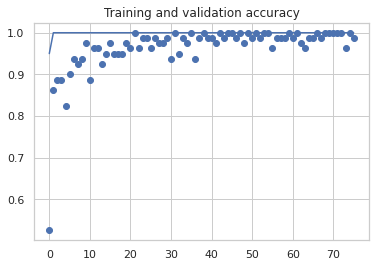

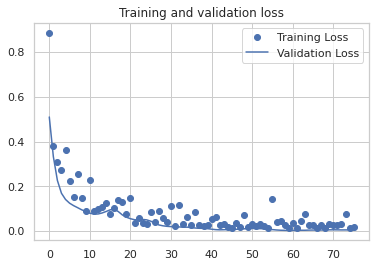

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# import some of library that we need to look the confusion matrix, recall, f1_score, and accuracy score to look how much your model is well
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

In [ ]:
# loading model to evaluate more depth
from keras.models import load_model
model_path = '/content/drive/MyDrive/Colab Notebooks/Modul Kecerdasan Buatan Pak Galih /7. Transfer Learning /model_drop_batch_weight_from_callback_2.h5'
model = load_model(model_path)

Found 20 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[10  0]
 [ 0 10]]


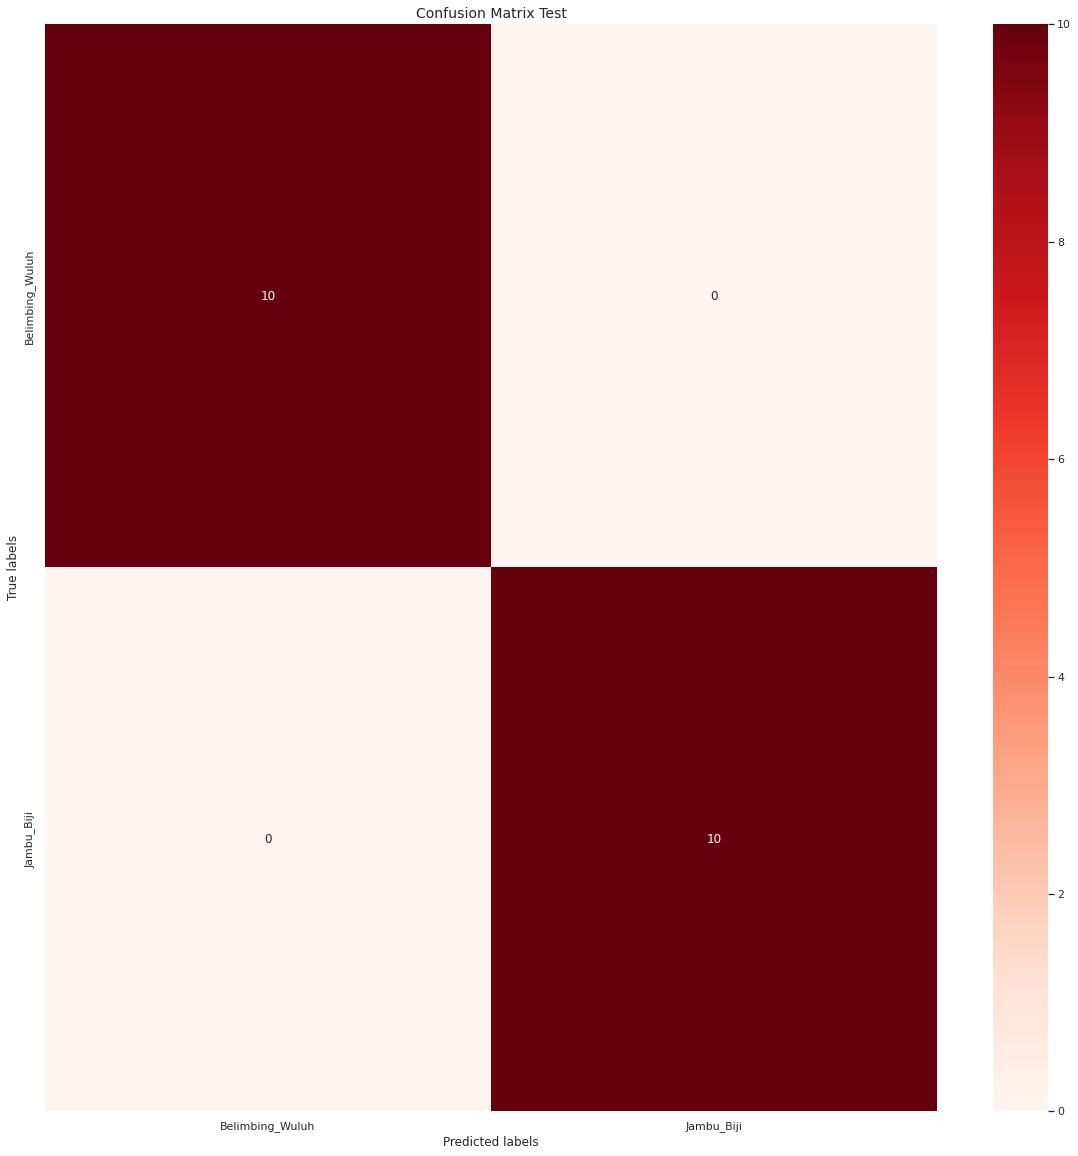

In [ ]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

height=224; width=224
batch_size=20

test_datagen = ImageDataGenerator(rescale=1./255)

TESTING_DIR = '/tmp/Dataset/Validation'

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size=batch_size,                                                             
                                                  target_size=(height, width),
                                                  class_mode= None,
                                                  shuffle=False
                                                  )

predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(20,20))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, yPredictions, target_names=class_names))

                 precision    recall  f1-score   support

Belimbing_Wuluh       1.00      1.00      1.00        10
     Jambu_Biji       1.00      1.00      1.00        10

       accuracy                           1.00        20
      macro avg       1.00      1.00      1.00        20
   weighted avg       1.00      1.00      1.00        20

